In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
%matplotlib inline
import matplotlib.pyplot as plt

# Creating Test Data

In [69]:
indexs = pd.read_csv("index.csv",index_col=0,thousands=',')
Countries = list(indexs)
dates = indexs.index.values
returns = pd.DataFrame(columns=Countries) #creates a new dataframe that's empty
#row1 = pd.to_numeric(indexs.values[1])
return_ = []
for i in range(1, len(indexs.index)):
    index_this_year = pd.to_numeric(indexs.values[i])
    index_last_year = pd.to_numeric(indexs.values[i-1])
    
    return_ = (index_this_year - index_last_year ) / index_last_year
    #returns.append(return_)
    returns.loc[i-1] = return_
returns.head()
mnthly_exp_returns = returns.mean()
mnthly_std_dev = returns.std()
returns.head()

yrly_exp_returns_test = (1+mnthly_exp_returns)**12 -1
yrly_exp_returns_test['R_f'] = .05
yrly_exp_returns_test = yrly_exp_returns_test.sort_index()


yrly_std_dev = mnthly_std_dev * 12**.5
yrly_std_dev['R_f'] = 0
yrly_std_dev = yrly_std_dev.sort_index()


corrleations_test = returns.corr()
corrleations_test['R_f']=0
corrleations_test.loc['R_f'] =0

corrleations_test = corrleations_test.sort_index()
corrleations_test = corrleations_test.sort_index(axis=1)


covariances_test = corrleations_test.multiply(yrly_std_dev,axis="rows")
covariances_test = covariances_test.multiply(yrly_std_dev,axis="columns")


In [46]:
yrly_exp_returns_test

Canada       0.123275
China        0.056155
France       0.127095
Hong Kong    0.221509
Japan        0.070551
R_f          0.050000
UK           0.128899
US           0.108345
dtype: float64

In [47]:
yrly_std_dev

Canada       0.200753
China        0.367033
France       0.230223
Hong Kong    0.355929
Japan        0.186011
R_f          0.000000
UK           0.224306
US           0.156796
dtype: float64

In [48]:
corrleations_test

,Canada,China,France,Hong Kong,Japan,R_f,UK,US
Canada,1.000000,0.534138,0.543841,0.420999,0.402378,0,0.566991,0.742841
China,0.534138,1.000000,0.395142,0.682695,0.276738,0,0.445682,0.481162
France,0.543841,0.395142,1.000000,0.346736,0.368029,0,0.618103,0.566168
Hong Kong,0.420999,0.682695,0.346736,1.000000,0.281356,0,0.418880,0.389865
Japan,0.402378,0.276738,0.368029,0.281356,1.000000,0,0.368411,0.411739
R_f,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000
UK,0.566991,0.445682,0.618103,0.418880,0.368411,0,1.000000,0.581110
US,0.742841,0.481162,0.566168,0.389865,0.411739,0,0.581110,1.000000


# The Model

In [49]:
def solve_std_dev(weights,covariances,yrly_exp_returns):
    Variance = np.dot(weights,covariances)
    Variance = np.dot(Variance,weights)
    weights_ER = yrly_exp_returns * weights
    Expeted_Return = sum(weights_ER)
    std_dev = Variance**.5
    #Sharpe_Ratio = (Expeted_Return - yrly_exp_returns['R_f']) / std_dev
    return Expeted_Return,std_dev,Variance

weights_test = [0.414231,-0.739657,0.176381,0.760777,-0.279501,0.103992,0.144610,0.419167]

Expeted_Return,std_dev,Variance = solve_std_dev(weights_test,covariances_test,yrly_exp_returns_test)

assert round(Expeted_Return,6) == 0.250000
assert std_dev == 0.25698684000142075
assert round(Variance,6) == 0.066042
print ("Expected Return of Spreadsheet Example = ",round(Expeted_Return,3))
print ("StdDev of Spreadsheet Example = ",round(std_dev,3))
print ("Variance of Spreadsheet Example = ",round(Variance,3))


Expected Return of Spreadsheet Example =  0.25
StdDev of Spreadsheet Example =  0.257
Variance of Spreadsheet Example =  0.066


In [89]:
def solve_error(weights,Target_Expected_Return,covariances,yrly_exp_returns):

    Exp_return, std_dev, variance = solve_std_dev(weights,covariances,yrly_exp_returns)
    
    
    rtn_error = 1000000*(Target_Expected_Return - Exp_return)**2
    std_dev_error = std_dev**2

    total_error = rtn_error + std_dev_error
    
    debug_error.append(total_error)
    debug_iteration.append(len(debug_error))
    return total_error



In [81]:
def solve_for_StdDev_Weights(Target_Expected_Return,covariances,yrly_exp_returns):
    num_terms = len(covariances)
    weights = [1/num_terms]*num_terms
    
    cons = ({'type': 'eq',
            'fun' : lambda x: np.array([sum(x)-1]),
            'jac' : lambda x: np.array([1]*len(x))})
    

    res = minimize(solve_error, weights, args=(Target_Expected_Return,covariances,yrly_exp_returns), method='SLSQP',constraints=cons,options={'disp': False})
    weights_new = res.x
    

    
    
    
    
    solved_exp_return, solved_std_dev, solved_variance = solve_std_dev(weights_new,covariances,yrly_exp_returns)
    
    return solved_std_dev, weights_new

#Unit Test
Target_Expected_Return = .25
weights_test = [0.414231,-0.739657,0.176381,0.760777,-0.279501,0.103992,0.144610,0.419167]
solved_std_dev, weights = solve_for_StdDev_Weights(Target_Expected_Return,covariances_test,yrly_exp_returns_test)
solved_exp_return, solved_std_dev2, solved_variance = solve_std_dev(weights,covariances_test,yrly_exp_returns_test)

print("Expected Return = ",solved_exp_return)
print("Standard Deviation, method 1 = ",solved_std_dev)
print("Standard Deviation, method 2 = ",solved_std_dev2)

assert round(solved_exp_return,6) == 0.25
assert round(solved_std_dev,4) == 0.2570
assert round(solved_std_dev2,4) == 0.2570

print ("Weights:")
print(weights)
print ("Portfolio = ",sum(weights))
print ("Error = ",solve_error(weights,Target_Expected_Return,covariances_test,yrly_exp_returns_test))

Expected Return =  0.249999668674
Standard Deviation, method 1 =  0.257006548369
Standard Deviation, method 2 =  0.257006548369
Weights:
[ 0.43687524 -0.73934667  0.17086154  0.75707542 -0.27570066  0.09868954
  0.14628689  0.4052587 ]
Portfolio =  1.0
Error =  0.0660524756817


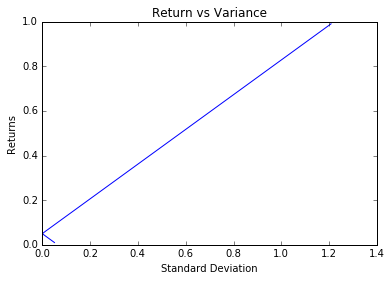

In [53]:
def rtn_variance_curve(yrly_exp_returns, yrly_std_dev, corrleations):
    covariances = corrleations.multiply(yrly_std_dev,axis="rows")
    covariances = covariances.multiply(yrly_std_dev,axis="columns")
    std_devs = []
    rtns = []

    for i in range(1,100):
        Target_Expected_Return = i/100
        rtns.append(Target_Expected_Return)
        solved_std_dev, weights = solve_for_StdDev_Weights(Target_Expected_Return, covariances, yrly_exp_returns)
        std_devs.append(solved_std_dev)

    plt.plot(std_devs,rtns)
    plt.title("Return vs Variance")
    plt.ylabel("Returns")
    plt.xlabel("Standard Deviation")
    
    return rtns, std_devs
    
rtns, std_devs = rtn_variance_curve(yrly_exp_returns_test, yrly_std_dev, corrleations_test)


# New Data

In [54]:
H1_corr = pd.read_csv("H1_correlation.csv",index_col=0,thousands=',')
H1_corr = H1_corr.sort_index()
H1_corr = H1_corr.sort_index(axis=1)
H1_corr.head()

,Absolute Return,Cash,Commodities,Domestic Bonds,Domestic Equity,Emerging Markets,Foreign Bonds,Foreign Equity,High Yield,Private Equity,Real Estate
Absolute Return,1.00,0.29,0.04,0.37,0.86,0.56,0.40,0.89,0.50,0.27,0.07
Cash,0.29,1.00,-0.20,0.28,0.14,-0.06,0.01,0.16,0.32,0.03,0.39
Commodities,0.04,-0.20,1.00,-0.09,0.00,-0.05,0.19,0.02,-0.32,0.05,-0.04
Domestic Bonds,0.37,0.28,-0.09,1.00,0.32,-0.09,0.42,0.22,0.31,-0.12,-0.06
Domestic Equity,0.86,0.14,0.00,0.32,1.00,0.37,0.10,0.51,0.56,0.26,0.06


In [55]:
H1_rtns = pd.read_csv("H1_returns.csv",index_col=0,thousands=',')
H1_sd = pd.read_csv("H1_sd.csv",index_col=0,thousands=',')

# Sort to ensure everything is in the same order
H1_rtns = H1_rtns.sort_index()
H1_sd = H1_sd.sort_index()

#convert from dataframe to series
H1_sd = H1_sd.iloc[:,0]
H1_rtns = H1_rtns.iloc[:,0]

# Convert to %
H1_rtns = H1_rtns /100
H1_sd =H1_sd /100

In [56]:
H1_rtns

Absolute Return     0.086
Cash                0.031
Commodities         0.011
Domestic Bonds      0.060
Domestic Equity     0.132
Emerging Markets    0.049
Foreign Bonds       0.051
Foreign Equity      0.102
High Yield          0.071
Private Equity      0.179
Real Estate         0.014
Name: Returns, dtype: float64

In [57]:
H1_sd

Absolute Return     0.086
Cash                0.009
Commodities         0.107
Domestic Bonds      0.078
Domestic Equity     0.152
Emerging Markets    0.212
Foreign Bonds       0.087
Foreign Equity      0.174
High Yield          0.073
Private Equity      0.152
Real Estate         0.064
Name: SD, dtype: float64

In [58]:
H1_corr

,Absolute Return,Cash,Commodities,Domestic Bonds,Domestic Equity,Emerging Markets,Foreign Bonds,Foreign Equity,High Yield,Private Equity,Real Estate
Absolute Return,1.00,0.29,0.04,0.37,0.86,0.56,0.40,0.89,0.50,0.27,0.07
Cash,0.29,1.00,-0.20,0.28,0.14,-0.06,0.01,0.16,0.32,0.03,0.39
Commodities,0.04,-0.20,1.00,-0.09,0.00,-0.05,0.19,0.02,-0.32,0.05,-0.04
Domestic Bonds,0.37,0.28,-0.09,1.00,0.32,-0.09,0.42,0.22,0.31,-0.12,-0.06
Domestic Equity,0.86,0.14,0.00,0.32,1.00,0.37,0.10,0.51,0.56,0.26,0.06
Emerging Markets,0.56,-0.06,-0.05,-0.09,1.00,1.00,-0.07,0.37,0.39,0.16,-0.08
Foreign Bonds,0.40,0.01,0.19,0.42,0.10,-0.07,1.00,0.40,-0.01,-0.30,-0.15
Foreign Equity,0.89,0.16,0.02,0.22,0.51,0.37,0.40,1.00,0.35,0.12,0.13
High Yield,0.50,0.32,-0.32,0.31,0.56,0.39,-0.01,0.35,1.00,0.06,-0.11
Private Equity,0.27,0.03,0.05,-0.12,0.26,0.16,-0.30,0.12,0.06,1.00,0.12


In [60]:
#rtns, std_devs = rtn_variance_curve(H1_rtns,H1_sd,H1_corr)

# Test Data 2

In [73]:
indexs = pd.read_csv("index.csv",index_col=0,thousands=',')
Countries = list(indexs)
dates = indexs.index.values
returns = pd.DataFrame(columns=Countries) #creates a new dataframe that's empty
#row1 = pd.to_numeric(indexs.values[1])
return_ = []
for i in range(1, len(indexs.index)):
    index_this_year = pd.to_numeric(indexs.values[i])
    index_last_year = pd.to_numeric(indexs.values[i-1])
    
    return_ = (index_this_year - index_last_year ) / index_last_year
    #returns.append(return_)
    returns.loc[i-1] = return_
returns.head()
mnthly_exp_returns = returns.mean()
mnthly_std_dev = returns.std()
returns.head()

yrly_exp_returns = (1+mnthly_exp_returns)**12 -1
yrly_exp_returns = yrly_exp_returns.sort_index()


yrly_std_dev = mnthly_std_dev * 12**.5
yrly_std_dev = yrly_std_dev.sort_index()


corrleations_test2 = returns.corr()

corrleations_test2 = corrleations_test2.sort_index()
corrleations_test2 = corrleations_test2.sort_index(axis=1)


covariances_test2 = corrleations_test2.multiply(yrly_std_dev,axis="rows")
covariances_test2 = covariances_test2.multiply(yrly_std_dev,axis="columns")


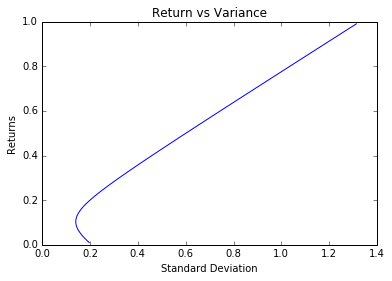

In [91]:
rtns, std_devs = rtn_variance_curve(yrly_exp_returns,yrly_std_dev,corrleations_test2)

In [90]:
global debug_error
global debug_iteration

debug_iteration = []
debug_error = []

In [76]:
corrleations_test

,Canada,China,France,Hong Kong,Japan,R_f,UK,US
Canada,1.000000,0.534138,0.543841,0.420999,0.402378,0,0.566991,0.742841
China,0.534138,1.000000,0.395142,0.682695,0.276738,0,0.445682,0.481162
France,0.543841,0.395142,1.000000,0.346736,0.368029,0,0.618103,0.566168
Hong Kong,0.420999,0.682695,0.346736,1.000000,0.281356,0,0.418880,0.389865
Japan,0.402378,0.276738,0.368029,0.281356,1.000000,0,0.368411,0.411739
R_f,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000
UK,0.566991,0.445682,0.618103,0.418880,0.368411,0,1.000000,0.581110
US,0.742841,0.481162,0.566168,0.389865,0.411739,0,0.581110,1.000000


In [77]:
corrleations_test2

,Canada,China,France,Hong Kong,Japan,UK,US
Canada,1.000000,0.534138,0.543841,0.420999,0.402378,0.566991,0.742841
China,0.534138,1.000000,0.395142,0.682695,0.276738,0.445682,0.481162
France,0.543841,0.395142,1.000000,0.346736,0.368029,0.618103,0.566168
Hong Kong,0.420999,0.682695,0.346736,1.000000,0.281356,0.418880,0.389865
Japan,0.402378,0.276738,0.368029,0.281356,1.000000,0.368411,0.411739
UK,0.566991,0.445682,0.618103,0.418880,0.368411,1.000000,0.581110
US,0.742841,0.481162,0.566168,0.389865,0.411739,0.581110,1.000000


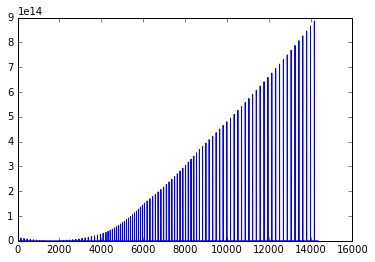

In [93]:


plt.plot(debug_iteration,debug_error)
